In [73]:
import pandas as pd
#import requests
#from pandas_profiling import ProfileReport
#import sweetviz as sv
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample

In [4]:
unnecessary_columns = ['V_ID','P_ID','C_YEAR','P_USER','P_PSN','V_YEAR','P_ISEV']

In [5]:
data_raw = pd.read_csv('./data/NCDB_1999_to_2014.csv',low_memory=False)

In [6]:
data_raw

,C_YEAR,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,...,V_ID,V_TYPE,V_YEAR,P_ID,P_SEX,P_AGE,P_PSN,P_ISEV,P_SAFE,P_USER
0,1999,01,1,20,2,02,34,UU,1,5,...,01,06,1990,01,M,41,11,1,UU,1
1,1999,01,1,20,2,02,34,UU,1,5,...,02,01,1987,01,M,19,11,1,UU,1
2,1999,01,1,20,2,02,34,UU,1,5,...,02,01,1987,02,F,20,13,2,02,2
3,1999,01,1,08,2,01,01,UU,5,3,...,01,01,1986,01,M,46,11,1,UU,1
4,1999,01,1,08,2,01,01,UU,5,3,...,99,NN,NNNN,01,M,05,99,2,UU,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5860400,2014,UU,U,UU,2,UU,UU,01,U,U,...,13,07,UUUU,01,M,24,11,1,NN,1
5860401,2014,UU,U,23,2,01,06,05,1,1,...,01,14,2006,01,M,29,96,2,09,5
5860402,2014,UU,U,14,2,01,02,01,1,5,...,01,01,2006,01,F,UU,11,2,01,1
5860403,2014,UU,U,22,1,01,06,01,2,4,...,01,22,UUUU,01,M,67,12,3,01,U


# Limpieza inicial del dataset

### Se toma la columna C_SEV como target y el objetivo sera predecir si hay o no al menos una fatalidad en el accidente

In [7]:
crashes_by_driver_df = data_raw.copy()

In [8]:
#Agregar columna con cantidad de personas por accidente
collision_columns = [col for col in crashes_by_driver_df.columns if col[0]=="C"]
collision_people_count_df = crashes_by_driver_df[collision_columns+['P_ID']].drop_duplicates().groupby(collision_columns).size().reset_index().rename(columns={0:"C_PERS"}).drop_duplicates()

In [9]:
collision_people_count_df

,C_YEAR,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,C_RALN,C_TRAF,C_PERS
0,1999,01,1,00,2,01,01,01,1,4,1,18,1
1,1999,01,1,00,2,01,01,01,1,5,1,18,1
2,1999,01,1,00,2,01,01,01,2,1,1,18,1
3,1999,01,1,00,2,01,01,01,6,3,2,18,1
4,1999,01,1,00,2,01,01,UU,1,2,3,18,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1850390,2014,12,7,UU,2,02,UU,02,U,U,1,03,1
1850391,2014,UU,U,14,2,01,02,01,1,5,4,18,1
1850392,2014,UU,U,22,1,01,06,01,2,4,Q,18,2
1850393,2014,UU,U,23,2,01,06,05,1,1,U,18,1


### Se agrupan los datos por accidentes para que no haya accidentes repetidos, en cuanto a las columnas con los datos de las personas, se van a utilizar unicamente los datos del conductor de cada vehiculo

In [10]:
#quedarse solo con los drivers
crashes_by_driver_df = crashes_by_driver_df[crashes_by_driver_df['P_PSN']=="11"]
crashes_by_driver_df

,C_YEAR,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,...,V_ID,V_TYPE,V_YEAR,P_ID,P_SEX,P_AGE,P_PSN,P_ISEV,P_SAFE,P_USER
0,1999,01,1,20,2,02,34,UU,1,5,...,01,06,1990,01,M,41,11,1,UU,1
1,1999,01,1,20,2,02,34,UU,1,5,...,02,01,1987,01,M,19,11,1,UU,1
3,1999,01,1,08,2,01,01,UU,5,3,...,01,01,1986,01,M,46,11,1,UU,1
5,1999,01,1,17,2,03,QQ,QQ,1,2,...,01,01,1984,01,M,28,11,1,UU,1
6,1999,01,1,17,2,03,QQ,QQ,1,2,...,02,01,1991,01,M,21,11,1,UU,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5860397,2014,UU,U,UU,2,UU,UU,01,U,U,...,10,01,UUUU,01,F,79,11,1,NN,1
5860398,2014,UU,U,UU,2,UU,UU,01,U,U,...,11,01,UUUU,01,F,20,11,1,NN,1
5860399,2014,UU,U,UU,2,UU,UU,01,U,U,...,12,01,UUUU,01,F,47,11,1,NN,1
5860400,2014,UU,U,UU,2,UU,UU,01,U,U,...,13,07,UUUU,01,M,24,11,1,NN,1


In [11]:
crashes_by_driver_df = crashes_by_driver_df.merge(collision_people_count_df,on=collision_columns,how='left')

In [12]:
print(f'Numero de registros: {crashes_by_driver_df.shape[0]}')
print(f'Numero de columnas: {crashes_by_driver_df.shape[1]}')

Numero de registros: 3926086
Numero de columnas: 23


In [13]:
crashes_by_driver_df.dtypes.to_dict()

{'C_YEAR': dtype('int64'),
 'C_MNTH': dtype('O'),
 'C_WDAY': dtype('O'),
 'C_HOUR': dtype('O'),
 'C_SEV': dtype('int64'),
 'C_VEHS': dtype('O'),
 'C_CONF': dtype('O'),
 'C_RCFG': dtype('O'),
 'C_WTHR': dtype('O'),
 'C_RSUR': dtype('O'),
 'C_RALN': dtype('O'),
 'C_TRAF': dtype('O'),
 'V_ID': dtype('O'),
 'V_TYPE': dtype('O'),
 'V_YEAR': dtype('O'),
 'P_ID': dtype('O'),
 'P_SEX': dtype('O'),
 'P_AGE': dtype('O'),
 'P_PSN': dtype('O'),
 'P_ISEV': dtype('O'),
 'P_SAFE': dtype('O'),
 'P_USER': dtype('O'),
 'C_PERS': dtype('int64')}

In [14]:
int_types = ["P_AGE","V_AGE","C_PERS","C_VEHS"]
categories = [col for col in data_raw.columns if col not in int_types + unnecessary_columns]
target = "C_SEV"

### Los valores U, X y N del dataset se reemplazan por valores nan , y los valores Q se los toma como otra categoria mas, la columna C_HOUR se la agrupa en intervalos de 6 horas, dejando solo 4 categorias.

In [15]:
def replace_categories_nas(data,categories):
    nas = ["UU","XX","U","X","XXXX","NN","NNNN","N","UUUU"]
    others = {
        "P_SAFE" : "14",
        "P_PSN": "100",
        "V_TYPE": "24",
        "C_TRAF": "19",
        "C_RALN": "7",
        "C_RSUR": "10",
        "C_WTHR": "8",
        "C_RCFG": "13",
        "C_CONF": "42"
    }
    data[categories] = data[categories].replace(to_replace=rf'^({"|".join(nas)})',value=pd.NA,regex=True)
    for key,value in others.items():
        data[key] = data[key].replace(to_replace=r'^Q.*', value=value, regex=True)

def transform_hour(value):
    value = pd.to_numeric(value,errors='coerce')
    if value >= 0 and value<6:
        return '0'
    if value >= 6 and value<12:
        return '1'
    if value >= 12 and value<18:
        return '2'
    if value >= 18 and value<24:
        return '3'
    return pd.NA

In [16]:
replace_categories_nas(crashes_by_driver_df,categories)
crashes_by_driver_df['C_HOUR'] = crashes_by_driver_df['C_HOUR'].apply(transform_hour) 


In [17]:
#agregar columna con antiguedad del coche
crashes_by_driver_df['V_AGE'] = crashes_by_driver_df['C_YEAR'] - pd.to_numeric(crashes_by_driver_df['V_YEAR'], errors='coerce')

In [18]:
crashes_by_driver_df[int_types] = crashes_by_driver_df[int_types].apply(pd.to_numeric, errors='coerce',downcast='integer')

In [19]:
crashes_by_driver_df = crashes_by_driver_df.drop(unnecessary_columns,1).drop_duplicates()
crashes_by_driver_df

C:\Users\remoteUser\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,C_RALN,C_TRAF,V_TYPE,P_SEX,P_AGE,P_SAFE,C_PERS,V_AGE
0,01,1,3,2,2.0,34,<NA>,1,5,3,03,06,M,41.0,<NA>,2,9.0
1,01,1,3,2,2.0,34,<NA>,1,5,3,03,01,M,19.0,<NA>,2,12.0
2,01,1,1,2,1.0,01,<NA>,5,3,6,18,01,M,46.0,<NA>,1,13.0
3,01,1,2,2,3.0,42,13,1,2,1,01,01,M,28.0,<NA>,2,15.0
4,01,1,2,2,3.0,42,13,1,2,1,01,01,M,21.0,<NA>,2,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3926070,12,7,0,2,1.0,04,01,2,2,1,18,01,M,49.0,02,1,20.0
3926071,12,7,3,2,1.0,02,01,2,5,1,18,01,M,20.0,02,1,4.0
3926072,12,7,2,2,2.0,41,01,1,5,1,18,05,M,44.0,02,3,6.0
3926073,12,7,3,2,1.0,03,01,1,3,4,18,01,F,35.0,02,3,13.0


In [20]:
crashes_by_driver_df[target] = crashes_by_driver_df[target].astype('int8')
crashes_by_driver_df[target] = crashes_by_driver_df[target].replace({2:0})

In [31]:
crashes_by_driver_df.to_csv('./data/crash_transformed_c_sev.csv',index=False)

# EDA

In [27]:
print(f"Features: {', '.join(crashes_by_driver_df.columns)}")
print(f'Numero de filas: {crashes_by_driver_df.shape[0]}')
print(f'Numero de Columnas: {crashes_by_driver_df.shape[1]}')

Features: C_MNTH, C_WDAY, C_HOUR, C_SEV, C_VEHS, C_CONF, C_RCFG, C_WTHR, C_RSUR, C_RALN, C_TRAF, V_TYPE, P_SEX, P_AGE, P_SAFE, C_PERS, V_AGE
Numero de filas: 3871270
Numero de Columnas: 17


In [22]:
df_dtypes = pd.merge(crashes_by_driver_df.isnull().sum(axis = 0).sort_values().to_frame('missing_value').reset_index(),
         crashes_by_driver_df.dtypes.to_frame('feature_type').reset_index(),
         on = 'index',
         how = 'inner')
df_dtypes

,index,missing_value,feature_type
0,C_SEV,0,int64
1,C_PERS,0,int8
2,C_MNTH,142,object
3,C_VEHS,243,float64
4,C_WDAY,832,object
5,V_TYPE,30364,object
6,C_HOUR,40330,object
7,C_RSUR,52468,object
8,C_WTHR,57515,object
9,C_CONF,126362,object


In [23]:
print(f'Registros Sin muertes {crashes_by_driver_df[crashes_by_driver_df[target]==0][target].count()}')
print(f'Registros Con muertes {crashes_by_driver_df[crashes_by_driver_df[target]==1][target].count()}')

Registros Sin muertes 3814337
Registros Con muertes 56933


<AxesSubplot:xlabel='C_SEV', ylabel='count'>

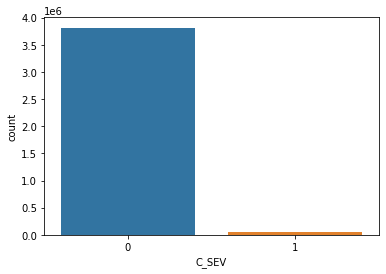

In [58]:
sns.countplot(x='C_SEV', data=crashes_by_driver_df)

El dataset esta desbalanceado.

#### Encoding

In [34]:
one_hot_categories = ['C_MNTH', 'C_WDAY', 'C_HOUR', 'P_SEX']
target_categories = ['C_CONF', 'C_RCFG', 'C_WTHR','C_RSUR','C_RALN','C_TRAF','V_TYPE','P_SAFE']

In [52]:
catboost_encoder = ce.CatBoostEncoder(cols=target_categories)
onehot_encoder = OneHotEncoder(handle_unknown='ignore')
#imputer = SimpleImputer(strategy='constant', fill_value='missing')

crashes_encoded = catboost_encoder.fit_transform(crashes_by_driver_df,crashes_by_driver_df['C_SEV'])
#onehot_encoder.fit_transform(imputer.fit_transform(crashes_by_driver_df[one_hot_categories].replace(pd.NA,np.nan)))
#crashes_encoded = pd.concat([crashes_encoded,pd.get_dummies(crashes_by_driver_df[one_hot_categories])])
#crashes_encoded
crashes_encoded = crashes_encoded.join(pd.get_dummies(crashes_by_driver_df[one_hot_categories]))
crashes_encoded = crashes_encoded.drop(one_hot_categories,axis=1)
crashes_encoded

,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,C_RALN,C_TRAF,V_TYPE,P_AGE,...,C_WDAY_4,C_WDAY_5,C_WDAY_6,C_WDAY_7,C_HOUR_0,C_HOUR_1,C_HOUR_2,C_HOUR_3,P_SEX_F,P_SEX_M
0,0,2.0,0.014707,0.014707,0.014707,0.014707,0.014707,0.014707,0.014707,41.0,...,0,0,0,0,0,0,0,1,0,1
1,0,2.0,0.007353,0.014707,0.007353,0.007353,0.007353,0.007353,0.014707,19.0,...,0,0,0,0,0,0,0,1,0,1
2,0,1.0,0.014707,0.014707,0.014707,0.014707,0.014707,0.014707,0.007353,46.0,...,0,0,0,0,0,1,0,0,0,1
3,0,3.0,0.014707,0.014707,0.004902,0.014707,0.014707,0.014707,0.004902,28.0,...,0,0,0,0,0,0,1,0,0,1
4,0,3.0,0.007353,0.007353,0.003677,0.007353,0.007353,0.007353,0.003677,21.0,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3926070,0,1.0,0.029262,0.024072,0.017913,0.012653,0.012181,0.021062,0.012431,49.0,...,0,0,0,1,1,0,0,0,0,1
3926071,0,1.0,0.022566,0.024072,0.017913,0.016495,0.012181,0.021062,0.012431,20.0,...,0,0,0,1,0,0,0,1,0,1
3926072,0,2.0,0.016103,0.024072,0.013895,0.016494,0.012181,0.021061,0.014860,44.0,...,0,0,0,1,0,0,1,0,0,1
3926073,0,1.0,0.032828,0.024072,0.013895,0.016416,0.036601,0.021061,0.012431,35.0,...,0,0,0,1,0,0,0,1,1,0


In [54]:
crashes_encoded.describe()

,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,C_RALN,C_TRAF,V_TYPE,P_AGE,...,C_WDAY_4,C_WDAY_5,C_WDAY_6,C_WDAY_7,C_HOUR_0,C_HOUR_1,C_HOUR_2,C_HOUR_3,P_SEX_F,P_SEX_M
count,3.871270e+06,3.871027e+06,3.871270e+06,3.871270e+06,3.871270e+06,3.871270e+06,3.871270e+06,3.871270e+06,3.871270e+06,3.680669e+06,...,3.871270e+06,3.871270e+06,3.871270e+06,3.871270e+06,3.871270e+06,3.871270e+06,3.871270e+06,3.871270e+06,3.871270e+06,3.871270e+06
mean,1.470654e-02,2.095941e+00,1.504900e-02,1.581399e-02,1.516152e-02,1.507649e-02,1.571154e-02,1.499776e-02,1.494437e-02,3.958039e+01,...,1.549597e-01,1.719219e-01,1.344928e-01,1.073586e-01,6.209435e-02,2.561885e-01,4.523745e-01,2.189248e-01,3.611241e-01,6.014101e-01
std,1.203755e-01,1.306370e+00,1.903022e-02,8.118625e-03,4.369877e-03,2.026519e-03,6.739244e-03,7.604311e-03,9.564831e-03,1.644211e+01,...,3.618663e-01,3.773126e-01,3.411811e-01,3.095686e-01,2.413269e-01,4.365272e-01,4.977267e-01,4.135176e-01,4.803265e-01,4.896081e-01
min,0.000000e+00,1.000000e+00,1.895173e-05,3.083133e-05,8.308782e-05,2.917965e-05,2.042575e-04,1.732219e-05,1.256970e-04,1.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,2.000000e+00,3.638217e-03,8.821756e-03,1.381601e-02,1.463185e-02,1.247693e-02,4.836936e-03,1.252038e-02,2.600000e+01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,2.000000e+00,1.215294e-02,9.125494e-03,1.409233e-02,1.496812e-02,1.267346e-02,2.080977e-02,1.270016e-02,3.800000e+01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,0.000000e+00,2.000000e+00,1.578779e-02,2.526596e-02,1.429486e-02,1.527739e-02,1.470654e-02,2.131449e-02,1.290884e-02,5.100000e+01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
max,1.000000e+00,7.700000e+01,7.536766e-01,3.484655e-01,2.313349e-01,1.549774e-01,2.029413e-01,2.878152e-01,5.073533e-01,9.900000e+01,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [55]:
crashes_encoded.groupby('C_SEV').mean()

,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,C_RALN,C_TRAF,V_TYPE,P_AGE,P_SAFE,...,C_WDAY_4,C_WDAY_5,C_WDAY_6,C_WDAY_7,C_HOUR_0,C_HOUR_1,C_HOUR_2,C_HOUR_3,P_SEX_F,P_SEX_M
C_SEV,,,,,,,,,,,,,,,,,,,,,
0,2.091424,0.014681,0.015752,0.015146,0.015073,0.015665,0.014941,0.014858,39.551843,0.014991,...,0.155108,0.171947,0.134054,0.106836,0.060841,0.256550,0.453916,0.218295,0.363338,0.598978
1,2.398591,0.039718,0.019943,0.016184,0.015310,0.018855,0.018831,0.020729,41.444392,0.024445,...,0.145013,0.170270,0.163859,0.142395,0.146049,0.231974,0.349130,0.261114,0.212829,0.764337


#### Distribucion

I:\Anaconda\envs\machine_learning_base\lib\site-packages\seaborn\axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


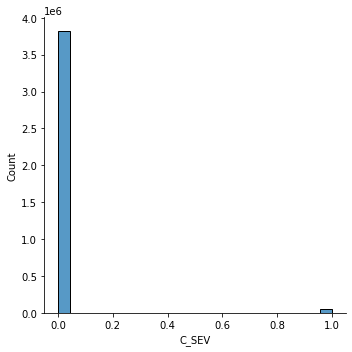

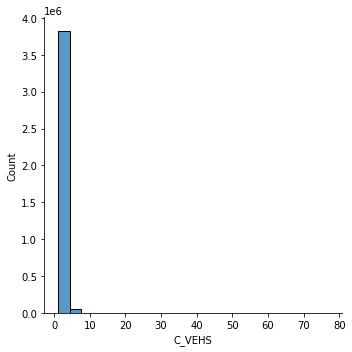

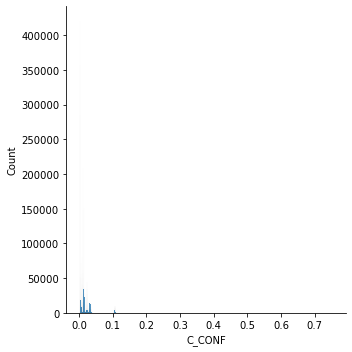

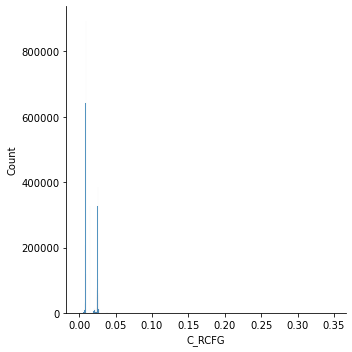

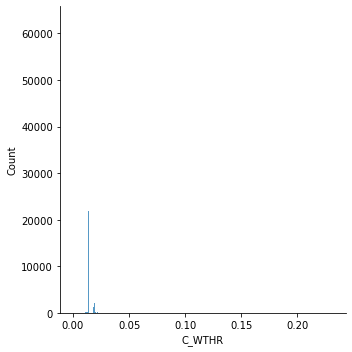

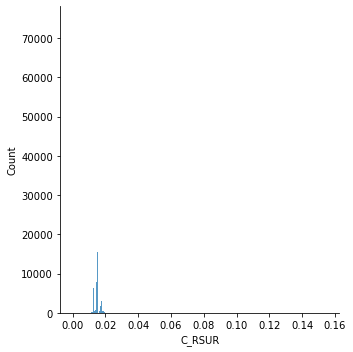

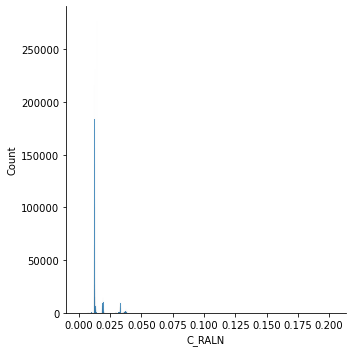

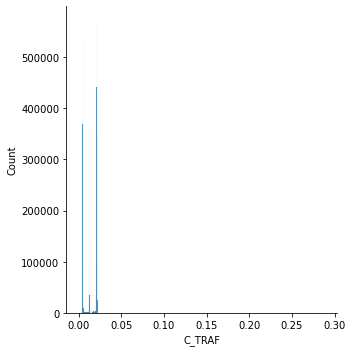

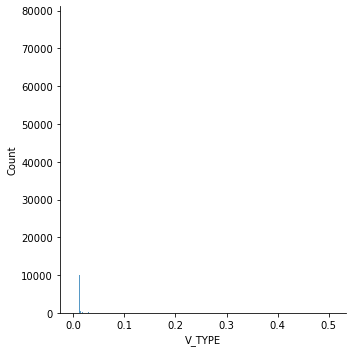

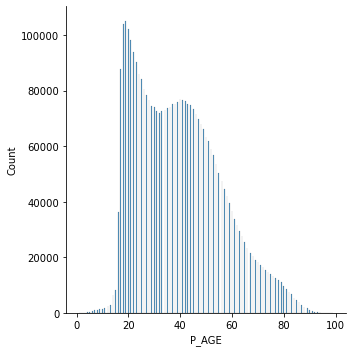

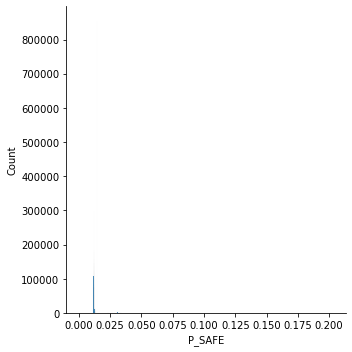

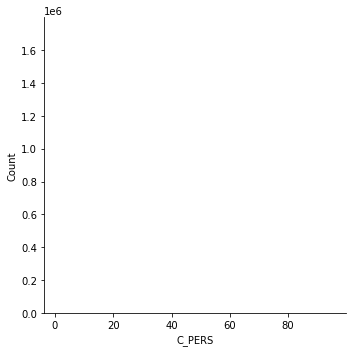

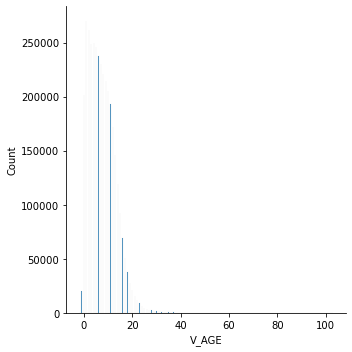

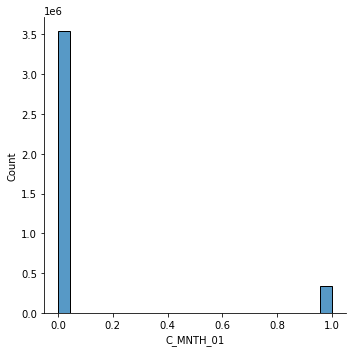

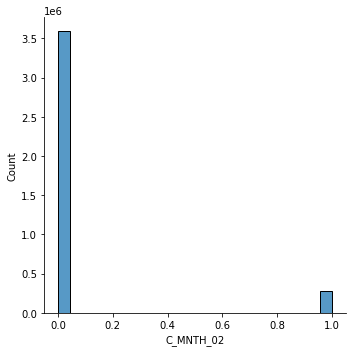

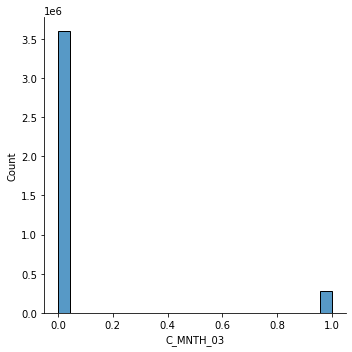

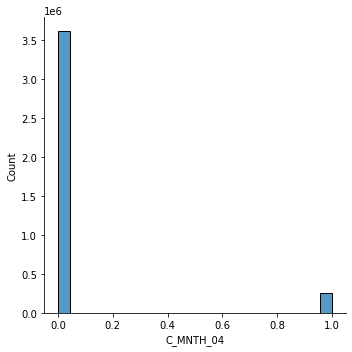

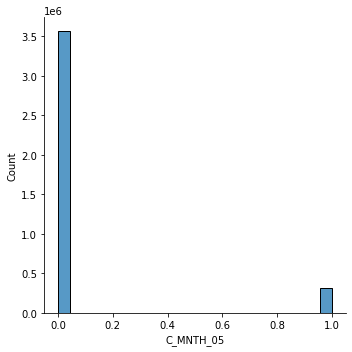

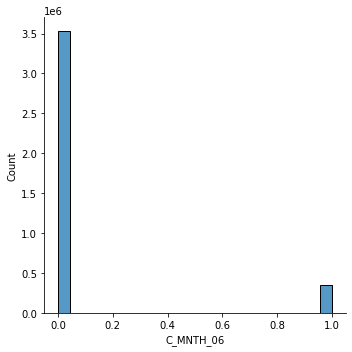

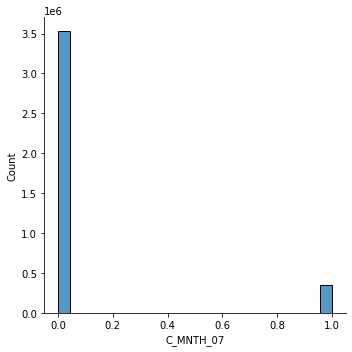

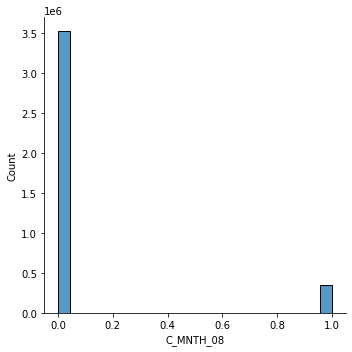

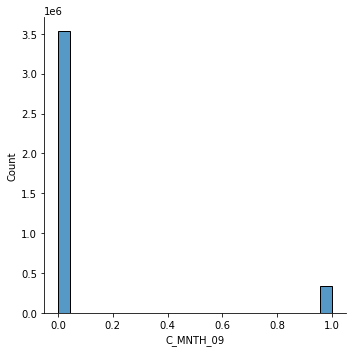

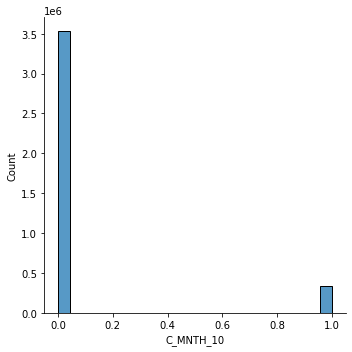

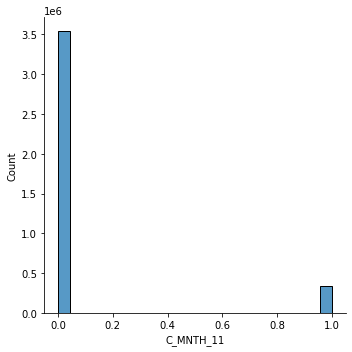

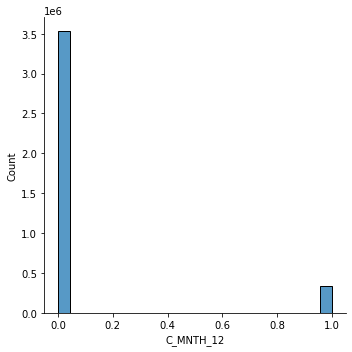

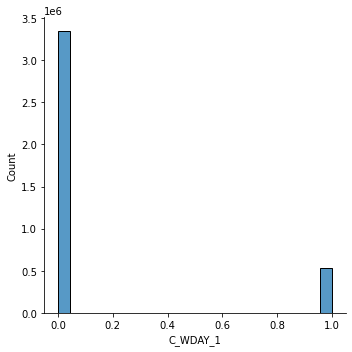

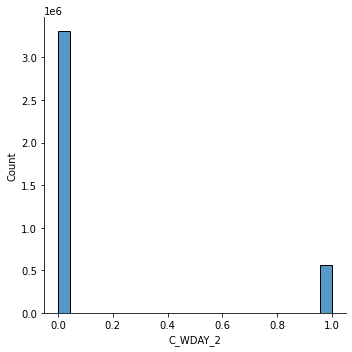

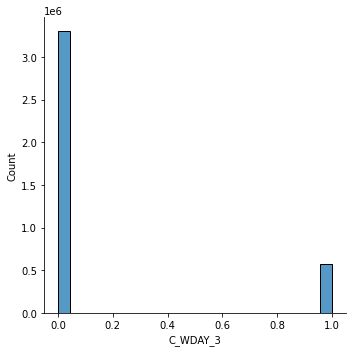

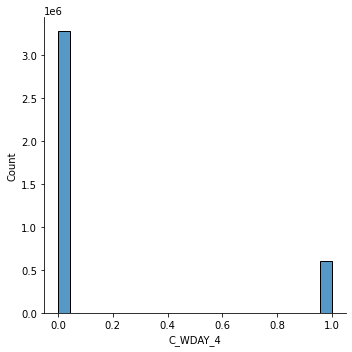

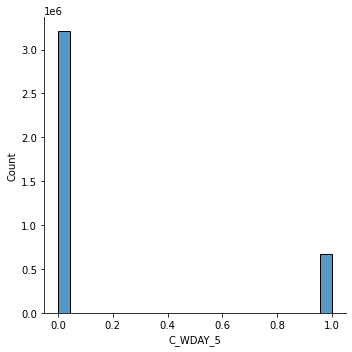

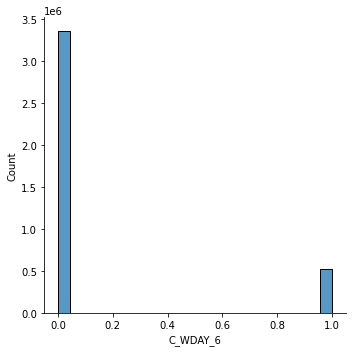

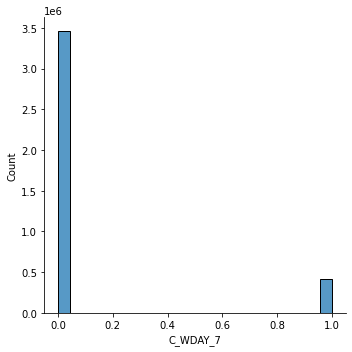

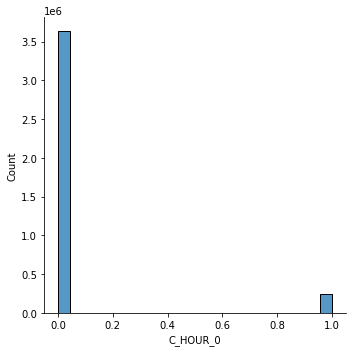

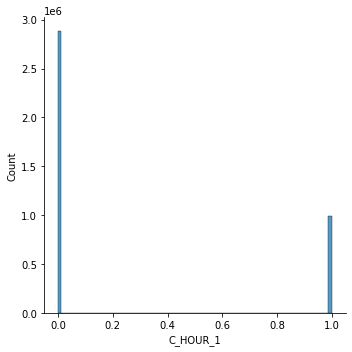

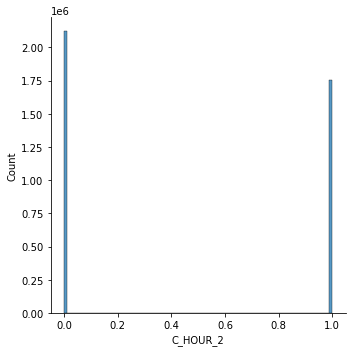

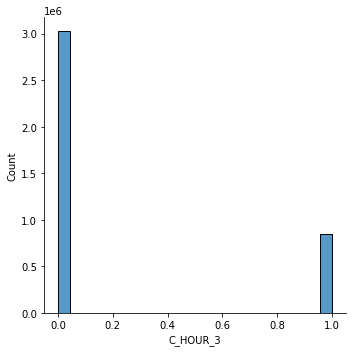

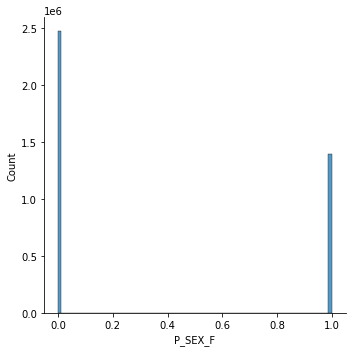

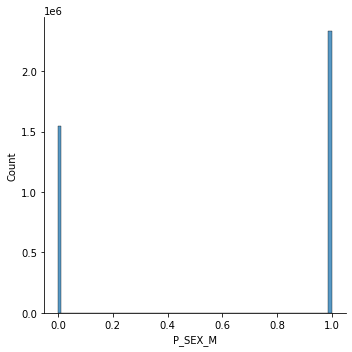

In [59]:
for column in crashes_encoded:
    sns.displot(x=column, data=crashes_encoded)

#### Correlacion

<AxesSubplot:>

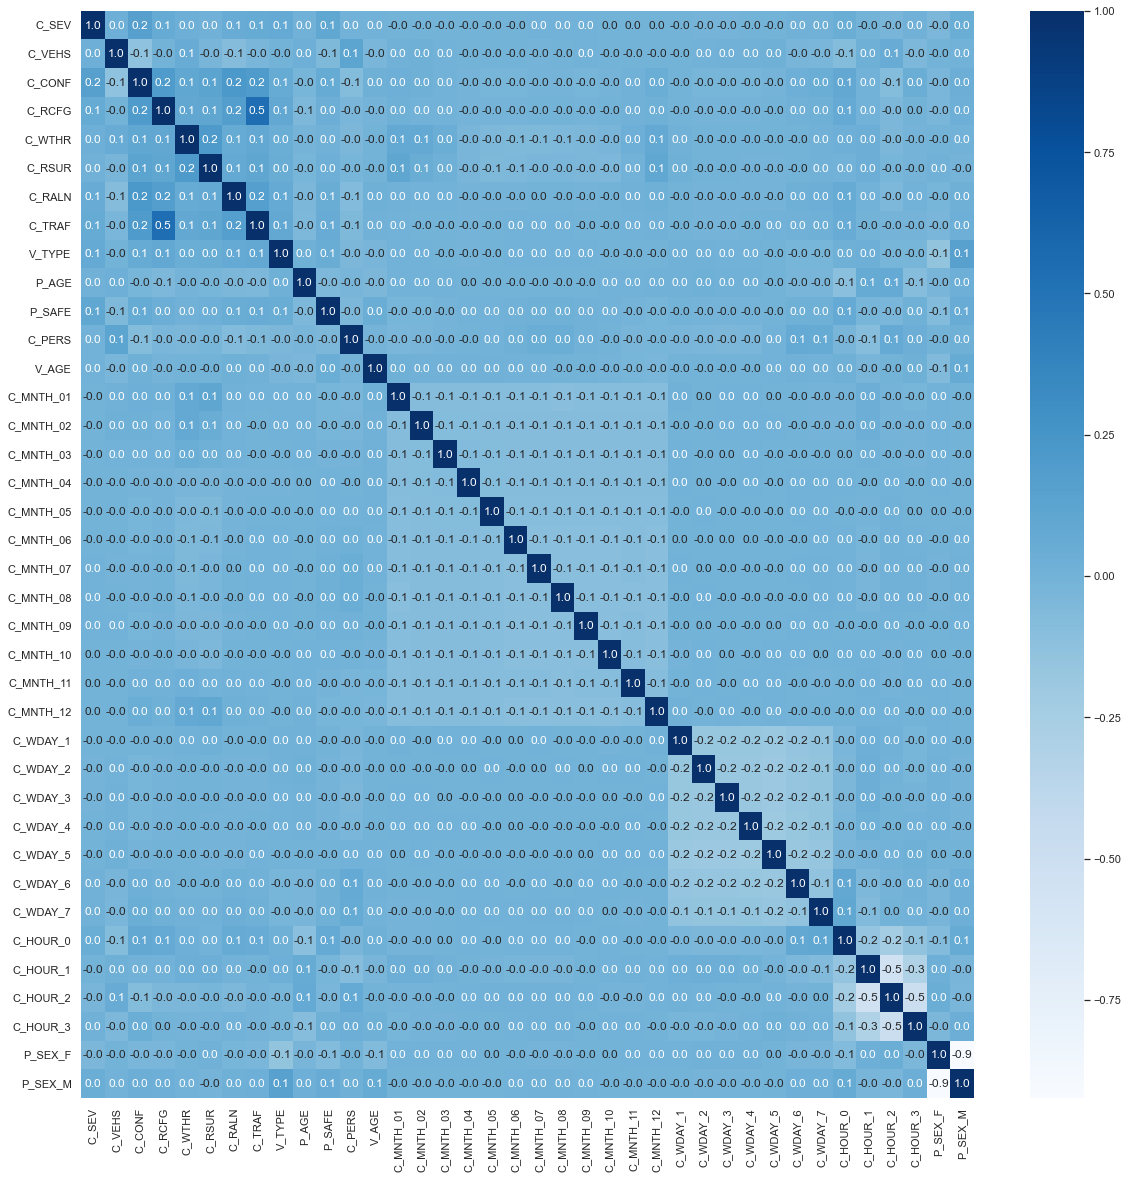

In [65]:
correlation_matrix = crashes_encoded.corr()
plt.figure(figsize=(20,20))
sns.heatmap(correlation_matrix, cbar=True, fmt='.1f', annot=True, cmap='Blues')

Las unicas variables altamente correlacionadas son las del sexo, despues se puede observar que C_TRAF y C_RCFG tienen una correlacion positiva de 0.5, tambien se puede ver una correlacion negativa entre C_HOUR_2,C_HOUR_1 y C_HOUR_2,C_HOUR_3

#### Outliers

C:\Users\remoteUser\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


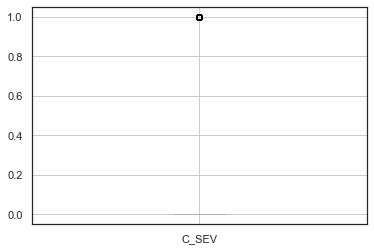

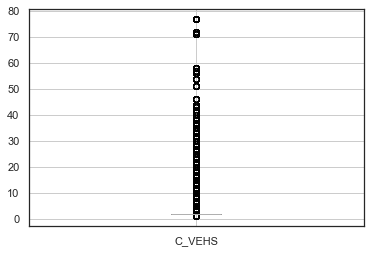

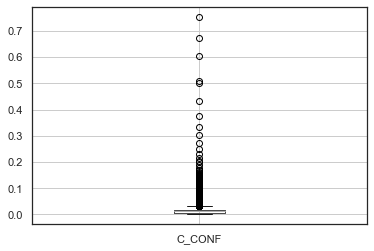

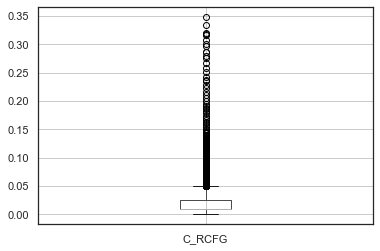

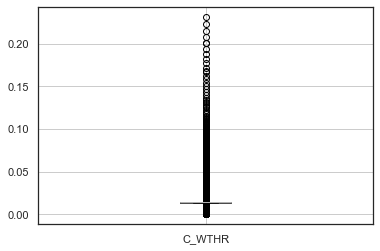

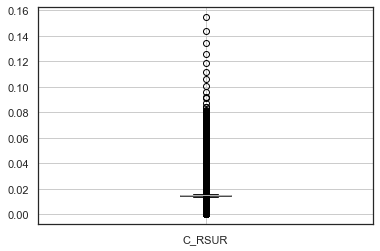

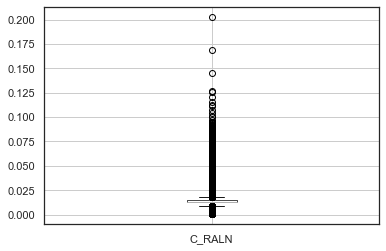

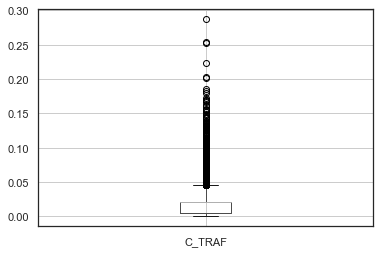

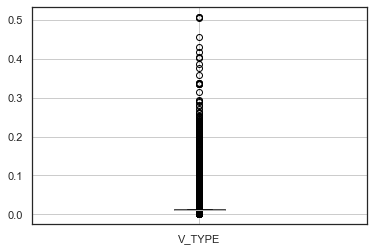

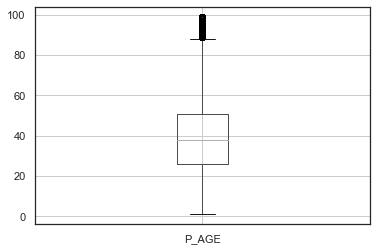

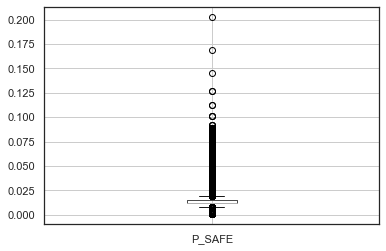

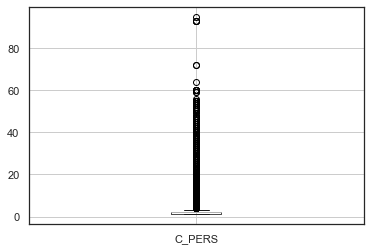

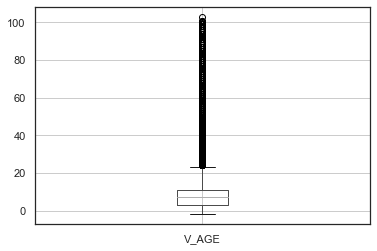

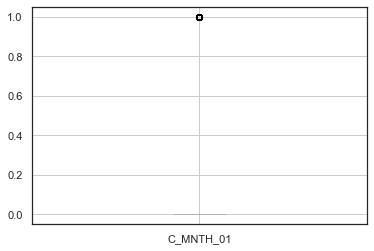

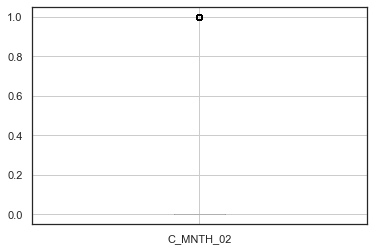

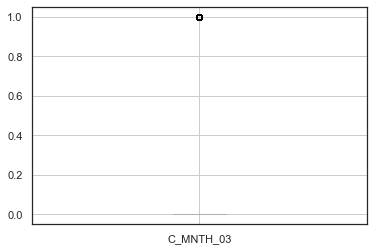

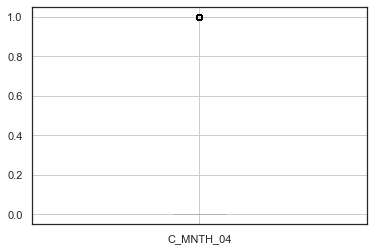

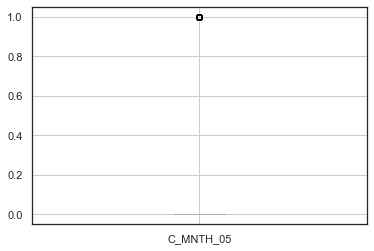

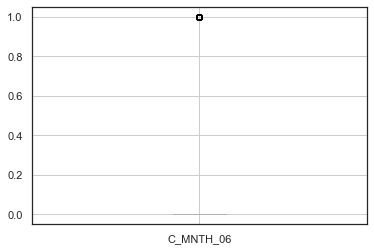

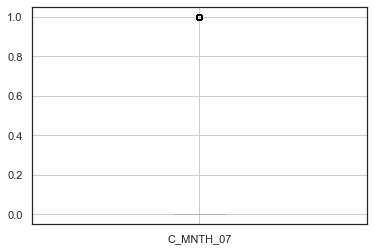

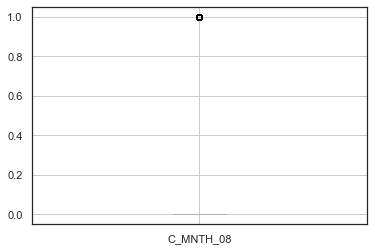

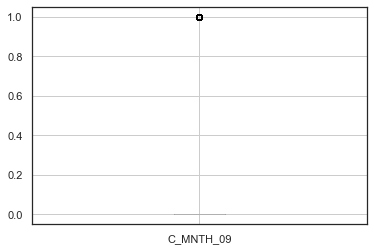

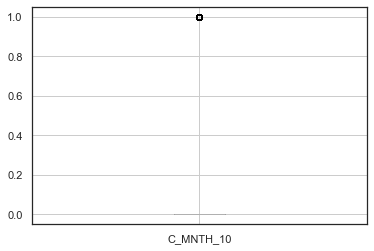

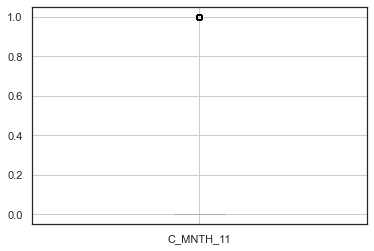

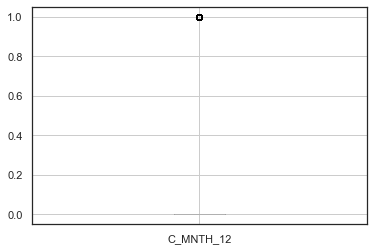

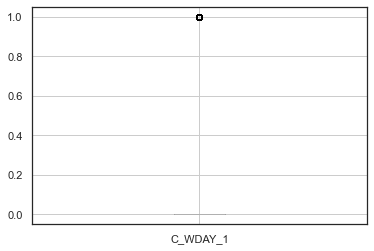

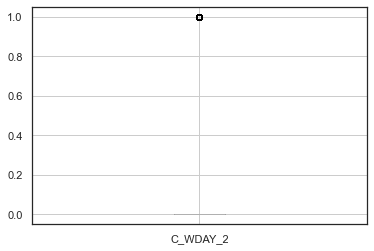

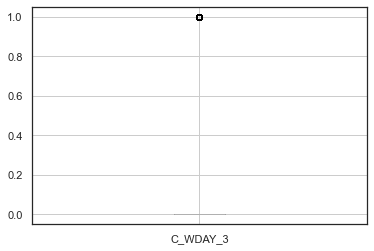

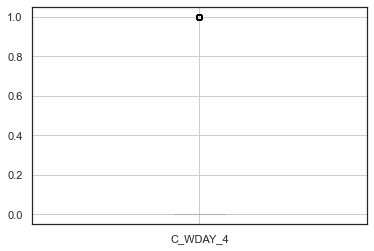

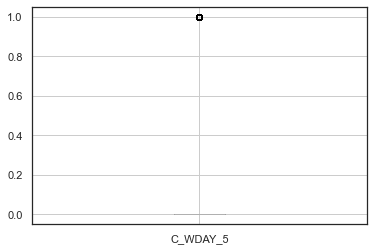

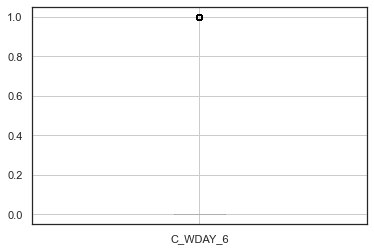

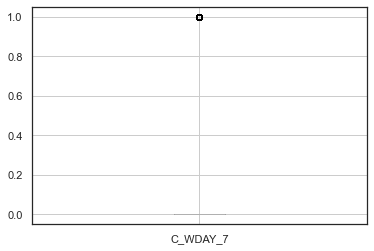

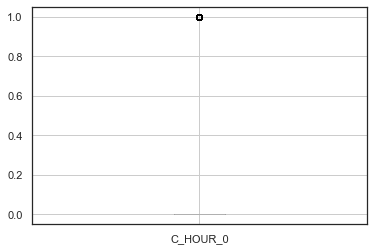

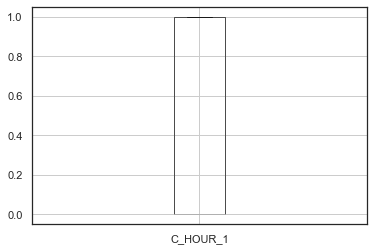

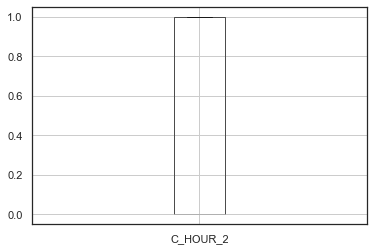

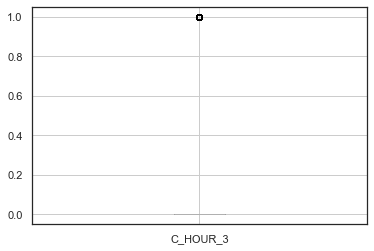

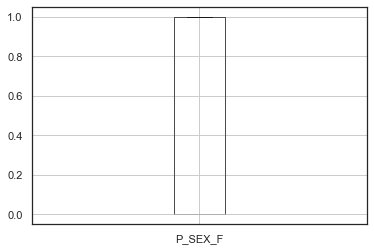

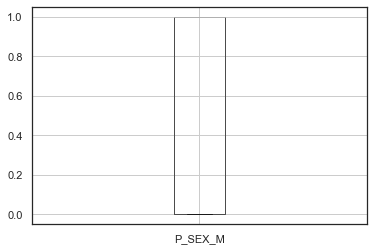

In [64]:
for column in crashes_encoded:
    plt.figure()
    crashes_encoded.boxplot([column])

Se puede observar una alta cantidad de outliers en la mayoria de las variables

#### Analisis de dimensionalidad

Separacion en train y test y balanceo del dataset de train

In [95]:
X = crashes_encoded.drop('C_SEV',axis=1)
y = crashes_encoded['C_SEV']

In [96]:
imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)
scaler = StandardScaler()
scaler.fit(X)

StandardScaler()

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [98]:
def subsample_data(X,y):
    y_2 = resample(y[y==0], replace = True, n_samples = len(y[y==1]), random_state = 12345)
    y_resampled = pd.concat([y[y==1],y_2])
    data_resampled = X.join(y_resampled)
    data_resampled = data_resampled.dropna(subset=[y.name])
    _y = data_resampled[y.name].astype('int8')
    _x = data_resampled.drop(target,axis=1)
    return _x,_y

X_train,y_train = subsample_data(X_train,y_train)

In [99]:
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

In [100]:
sel_ridge = SelectFromModel(LogisticRegression(C=1, penalty='l2'), threshold = 0.009)
sel_ridge.fit(X_train, y_train)

SelectFromModel(estimator=LogisticRegression(C=1), threshold=0.009)

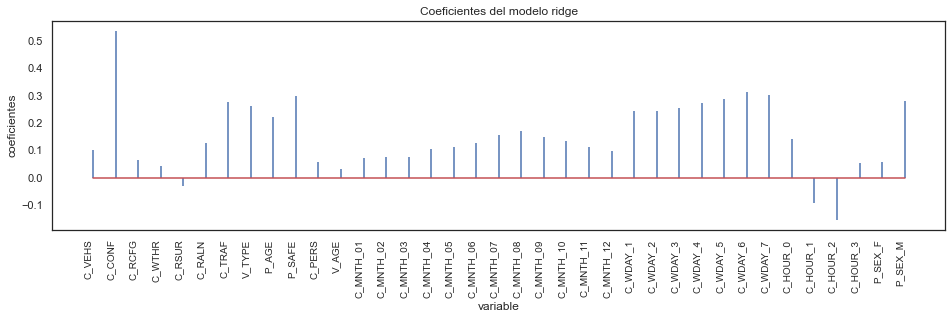

In [101]:
df_coeficientes = pd.DataFrame(
    {'predictor': X_train.columns,
     'coef': sel_ridge.estimator_.coef_.flatten()}
)

fig, ax = plt.subplots(figsize=(16, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo ridge');

In [102]:
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(X_train.columns[sel_ridge.get_support()])))

total features: 37
selected features: 37
